# 788 Project - Basic 2

Primary Resource for this code was https://pykit.org/chatbot-in-python-using-nlp/ for loading in the data, pre-processing it, and creating the chatbot. The Nueral Network and hyperparamters were modified by us to fit our specific application and needs.

Using this solution for our purposes involved heavily reformatting our data to use this model which is why there is only a small sample of data used. 



In [15]:
#mouting google drive to import data saved on it
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import Libraries

In [16]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import random
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd

Creating the Lemmatizer and importing the modified (sample) dataset in json form

In [17]:
lemmatizer = WordNetLemmatizer()

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("/content/drive/MyDrive/QA.json").read()
intents = json.loads(data_file)

Data Pre-Processing

Tokenizing the words

In [18]:
nltk.download('punkt')
nltk.download('wordnet')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lematizing the words and sorting 

In [19]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)

# creating a pickle file to store the Python objects which we will use while predicting
pickle.dump(words,open('words.pkl','wb')) 
pickle.dump(classes,open('classes.pkl','wb'))

60 documents
14 classes ['1', '2', 'Amedo Avogadro', 'Anders Celsius', 'Calvin Coolidge', 'Canada', 'Egypt', 'Elephant', 'Exit', 'Finland', 'Gerald Ford', 'Intro', 'beetle', 'duck']
138 unique lemmatized words ["'s", ',', 'a', 'abraham', 'adapted', 'addition', 'african', 'after', 'aifl', 'aiml', 'am', 'amedo', 'amherst', 'and', 'anders', 'anyone', 'are', 'atmospheric', 'avogadro', 'avogradro', 'batch', 'beetle', 'belong', 'best', 'blended', 'body', 'boiling', 'buddy', 'canada', 'catch', 'celcius', 'champlain', 'contribution', 'coolidge', 'cya', 'day', 'de', 'dependence', 'determined', 'did', 'do', 'doe', 'duck', 'education', 'egypt', 'elephant', 'else', 'establish', 'finland', 'first', 'fish', 'for', 'ford', 'formal', 'from', 'good', 'goodbye', 'graduating', 'great', 'have', 'hello', 'help', 'helped', 'hey', 'hi', 'his', 'house', 'how', 'i', 'in', 'is', 'large', 'later', 'learner', 'learning', 'leaving', 'lie', 'lincoln', 'listen', 'live', 'living', 'long', 'lot', 'many', 'me', 'member

Creating Training Data

Training data for this example is formated into a 'Bag of words'. This allows the Neural Network to learn the context of the sentences and how many times each word appear in a given sentence. 

From there, the data is shuffled and put into numpy arrays for training purposes

In [20]:
# create our training data
training = []

# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
   
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

# shuffle features and converting it into numpy arrays
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


# Creating NN Model

The model from the pykit example had very good results but for our project we wanted to design our own so adding more dense and dropout layers, adjusting the activation layers, and switching to a different optimizer allowed us maintain a very high accuracy, achive a low loss, and train on less epochs than the example.

If we were using our entire dataset, we may have to modify these hyperparameters based on the results with more question and asnwer pairs.

In [21]:
model = Sequential()
model.add(Dense(256, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.25))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#fitting and saving the model 
history = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=5)
model.save('chatbot.h5', history) # we will pickle this model to use in the future

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Epoch 1/100
12/12 [==============================] - 0s 2ms/step - loss: 3.5939 - accuracy: 0.0667
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 2.6112 - accuracy: 0.2667
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 2.1399 - accuracy: 0.3167
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 2.0914 - accuracy: 0.3333
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 2.0658 - accuracy: 0.2833
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.9375 - accuracy: 0.4500
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.9999 - accuracy: 0.4333
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 1.8632 - accuracy: 0.4500
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.6570 - accuracy: 0.4500
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 1.7020 - accuracy: 0.4500
Epoch 11/

In [22]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               35584     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

### Repeating all the above steps and using the pickled model for the prediction of responses

The following portion of code is from the Pykit example and uses the previously created model to predict the answers based on user input.

In [23]:
# load the saved model file
model = load_model('chatbot.h5')
intents = json.loads(open("/content/drive/MyDrive/QA.json").read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [24]:
def clean_up_sentence(sentence):

    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words


# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):

    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)

    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
               
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
   
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    error = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>error]
    
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [25]:
# function to get the response from the model

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

# function to predict the class and get the response

def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [26]:
# function to start the chat bot which will continue till the user type 'end'

def start_chat():
    print("Bot: 788 CHATBOT! Ask away :)\n\n")
    while True:
        inp = str(input()).lower()
        if inp.lower()=="end":
            break
        if inp.lower()== '' or inp.lower()== '*':
            print('Please re-phrase your query!')
            print("-"*50)
        else:
            print(f"Bot: {chatbot_response(inp)}"+'\n')
            print("-"*50)

## Chatting with BOT using the Command Line Option

In [27]:
# start the chat bot
start_chat()

Bot: 788 CHATBOT! Ask away :)


was abraham lincoln sixteenth president
Bot: Yes

--------------------------------------------------
hwo long was lincoln's education
Bot: 18 Months

--------------------------------------------------
how many species of elephant are there
Bot: The African Elephant genus contains two (or, arguably, three) living species.

--------------------------------------------------
what are the parts of a beetle
Bot: The head, the thorax, and the abdomen

--------------------------------------------------
why do people in eqypt live close to the nile river?
Bot: The only arable agricultural land is found there

--------------------------------------------------
Where did champlain establish a settlement other than port royal?
Bot: Quebec City

--------------------------------------------------
What species of duck catch large fish?
Bot: The smew

--------------------------------------------------
end


# Plotting Training Loss

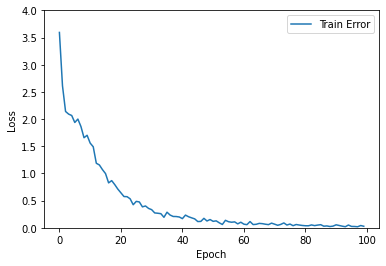

In [28]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.legend()
    plt.ylim([0, 4])

plot_history()